# TASK 1 — MODEL DEVELOPMENT & TRAINING

In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv("Integrated_Dataset_Harini_Mukesh.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df.sort_values(["Junction", "timestamp"])
df.head()


,DateTime,Junction,Vehicles,ID,timestamp,temperature,humidity,precipitation,windspeed,event_flag,event_type,date,hour,dayofweek
0,11/1/2015 0:00,1,15,20151101001,2015-11-01 00:00:00,24.4,96,0.2,10.1,0,none,11/1/2015,0,6
1,11/1/2015 1:00,1,13,20151101011,2015-11-01 01:00:00,24.4,95,0.3,10.6,0,none,11/1/2015,1,6
2,11/1/2015 2:00,1,10,20151101021,2015-11-01 02:00:00,25.1,92,0.2,10.4,0,none,11/1/2015,2,6
3,11/1/2015 3:00,1,7,20151101031,2015-11-01 03:00:00,25.9,88,0.5,11.0,0,none,11/1/2015,3,6
4,11/1/2015 4:00,1,9,20151101041,2015-11-01 04:00:00,27.0,82,0.2,10.3,0,none,11/1/2015,4,6


In [22]:
df.columns


Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'timestamp', 'temperature',
       'humidity', 'precipitation', 'windspeed', 'event_flag', 'event_type',
       'date', 'hour', 'dayofweek'],
      dtype='object')

In [23]:
# Ensure datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Time features
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)


In [24]:
df = df.sort_values(["Junction", "timestamp"])


In [25]:
df["lag_1h"] = df.groupby("Junction")["Vehicles"].shift(1)
df["lag_24h"] = df.groupby("Junction")["Vehicles"].shift(24)

# Handle missing values created by lags
df[["lag_1h", "lag_24h"]] = df[["lag_1h", "lag_24h"]].fillna(method="bfill")


C:\Users\harin\AppData\Local\Temp\ipykernel_1880\3048620294.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[["lag_1h", "lag_24h"]] = df[["lag_1h", "lag_24h"]].fillna(method="bfill")


In [26]:
features = [
    "hour", "dayofweek", "month", "is_weekend",
    "temperature", "humidity", "precipitation", "windspeed",
    "event_flag", "lag_1h", "lag_24h"
]

X = df[features]
y = df["Vehicles"]


In [27]:
X.head()
X.isna().sum()


hour             0
dayofweek        0
month            0
is_weekend       0
temperature      0
humidity         0
precipitation    0
windspeed        0
event_flag       0
lag_1h           0
lag_24h          0
dtype: int64

Time-based train–validation split

In [28]:
split_date = "2017-01-01"

X_train = X[df["timestamp"] < split_date]
X_val   = X[df["timestamp"] >= split_date]

y_train = y[df["timestamp"] < split_date]
y_val   = y[df["timestamp"] >= split_date]

print(X_train.shape, X_val.shape)


(30744, 11) (17476, 11)


Train baseline model (Random Forest)

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=12, n_estimators=200, n_jobs=-1,
                      random_state=42)

# TASK 2 — MODEL EVALUATION & CROSS-VALIDATION

Evaluate with MAE, RMSE, R²

In [40]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

y_pred = rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


MAE: 3.5622749834479324
RMSE: 6.0188838341754005
R2: 0.9459563611446633


Visual evaluation (plots)

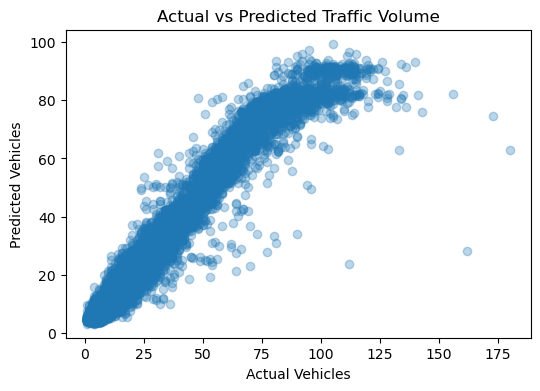

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel("Actual Vehicles")
plt.ylabel("Predicted Vehicles")
plt.title("Actual vs Predicted Traffic Volume")
plt.show()


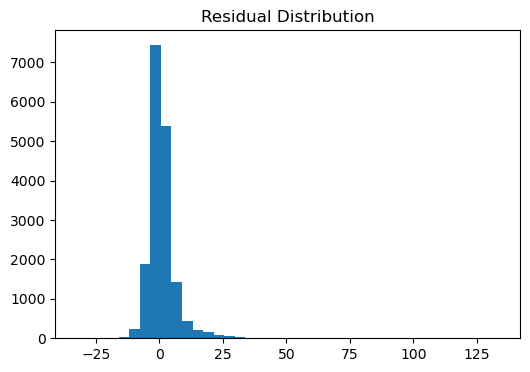

In [32]:
# Residuals

residuals = y_val - y_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40)
plt.title("Residual Distribution")
plt.show()

TimeSeries Cross-Validation

In [34]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []

for train_idx, test_idx in tscv.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    mae_scores.append(mean_absolute_error(y_te, preds))

print("Cross-Validation MAE per fold:", mae_scores)
print("Average CV MAE:", np.mean(mae_scores))


Cross-Validation MAE per fold: [5.6826530612244905, 2.7128036336485812, 2.6188352414136387, 3.082181433549029, 2.7478405804830643]
Average CV MAE: 3.3688627900637607


# TASK 3 — MODEL REFINEMENT

Feature importance (diagnosis)

In [35]:
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values(ascending=False)


lag_1h           0.943031
lag_24h          0.019092
hour             0.014451
windspeed        0.004898
temperature      0.004784
humidity         0.003911
month            0.003596
dayofweek        0.003479
precipitation    0.001615
is_weekend       0.000914
event_flag       0.000229
dtype: float64

Lag features and time-of-day variables are the strongest predictors.

In [36]:
# Reduce noise

refined_features = [
    "hour","dayofweek",
    "lag_1h","lag_24h",
    "temperature","event_flag"
]


In [ ]:
# Gradiant Boosting

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

# Train Gradient Boosting model
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)

# Predictions
y_pred_gbr = gbr.predict(X_val)

# RMSE evaluation (no warning)
rmse_gbr = root_mean_squared_error(y_val, y_pred_gbr)

print("Gradient Boosting RMSE:", rmse_gbr)


Gradient Boosting RMSE: 5.877891294611275
